# Validate and test a model

In [1]:
%pip install lightning --quiet --upgrade

## Add a test loop
To make sure a model can generalize to an unseen dataset (ie: to publish a paper or in a production environment) a dataset is normally split into two parts, the train split and the test split.

The test set is NOT used during training, it is ONLY used once the model has been trained to see how the model will do in the real-world.


### Find the train and test splits
Datasets come with two splits. Refer to the dataset documentation to find the train and test splits.

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import lightning as L
import torch.utils.data as data
from torchvision import datasets
import torchvision.transforms as transforms

In [3]:
# Load data sets
transform = transforms.ToTensor()
train_set = datasets.MNIST(root="MNIST", download=True, train=True, transform=transform)
test_set = datasets.MNIST(root="MNIST", download=True, train=False, transform=transform)

### Define the test loop
To add a test loop, implement the `test_step` method of the LightningModule

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, 3))

    def forward(self, x):
        return self.l1(x)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, 28 * 28))

    def forward(self, x):
        return self.l1(x)

In [5]:
class LitAutoEncoder(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat.view(x.size(0), 1, 28, 28)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, _ = batch
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # this is test loop
        x, _ = batch
        x_hat = self(x)
        test_loss = F.mse_loss(x_hat, x)
        self.log("test_loss", test_loss, on_step=True, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

### Train with the test loop
Once the model has finished training, call `.test()`

In [6]:
# model
autoencoder = LitAutoEncoder(Encoder(), Decoder())

# train model
trainer = L.Trainer(max_epochs=1, max_steps=1000)
trainer.fit(model=autoencoder, train_dataloaders=DataLoader(train_set))

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 50.4 K | train
1 | decoder | Decoder 

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=1000` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


In [7]:
# test the model
trainer.test(autoencoder, dataloaders=DataLoader(test_set))

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.05340554937720299    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.05340554937720299}]

## Add a validation loop
During training, it's common practice to use a small portion of the train split to determine when the model has finished training.

### Split the training data
As a rule of thumb, we use 20% of the training set as the validation set. This number varies from dataset to dataset.

In [8]:
# use 20% of training data for validation
train_set_size = int(len(train_set) * 0.8)
valid_set_size = len(train_set) - train_set_size

# split the train set into two
seed = torch.Generator().manual_seed(42)
train_set, valid_set = data.random_split(train_set, [train_set_size, valid_set_size], generator=seed)

### Define the validation loop
To add a validation loop, implement the `validation_step` method of the LightningModule

In [9]:
class LitAutoEncoder(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat.view(x.size(0), 1, 28, 28)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, _ = batch
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        x, _ = batch
        x_hat = self(x)
        val_loss = F.mse_loss(x_hat, x)
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        # this is test loop
        x, _ = batch
        x_hat = self(x)
        test_loss = F.mse_loss(x_hat, x)
        self.log("test_loss", test_loss, on_step=True, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

### Train with the validation loop
To run the validation loop, pass in the validation set to `.fit`

In [10]:
train_loader = DataLoader(train_set)
valid_loader = DataLoader(valid_set)
model = LitAutoEncoder(Encoder(), Decoder())

# train with both splits
trainer = L.Trainer(max_epochs=1, max_steps=1000)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 50.4 K | train
1 | decoder | Decoder 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=1000` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


# Saving and loading checkpoints

## What is a checkpoint?
When a model is training, the performance changes as it continues to see more data. It is a best practice to save the state of a model throughout the training process. This gives you a version of the model, a checkpoint, at each key point during the development of the model. Once training has completed, use the checkpoint that corresponds to the best performance you found during the training process.

Checkpoints also enable your training to resume from where it was in case the training process is interrupted.

PyTorch Lightning checkpoints are fully usable in plain PyTorch.

## Contents of a checkpoint
A Lightning checkpoint contains a dump of the model's entire internal state. Unlike plain PyTorch, Lightning saves everything you need to restore a model even in the most complex distributed training environments.

Inside a Lightning checkpoint you'll find:

- 16-bit scaling factor (if using 16-bit precision training)

- Current epoch

- Global step

- LightningModule's state_dict

- State of all optimizers

- State of all learning rate schedulers

- State of all callbacks (for stateful callbacks)

- State of datamodule (for stateful datamodules)

- The hyperparameters (init arguments) with which the model was created

- The hyperparameters (init arguments) with which the datamodule was created

- State of Loops

## Save a checkpoint
Lightning automatically saves a checkpoint for you in your current working directory, with the state of your last training epoch. This makes sure you can resume training in case it was interrupted.

In [11]:
trainer = L.Trainer(max_epochs=1, default_root_dir="./lightning_logs", max_steps=1000)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=valid_loader)
trainer.test(model, dataloaders=DataLoader(test_set))

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 50.4 K | train
1 | decoder | Decoder 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=1000` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │   0.049939341843128204    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.049939341843128204}]

## LightningModule from checkpoint
To load a LightningModule along with its weights and hyperparameters use the following method:

In [12]:
model = LitAutoEncoder.load_from_checkpoint("lightning_logs/lightning_logs/version_1/checkpoints/epoch=0-step=48000.ckpt", encoder=Encoder(), decoder=Decoder(), map_location="cpu")

# disable randomness, dropout, etc...
model.eval()

# predict with the model
sample_x = torch.rand(1, 28, 28)
y_hat = model(sample_x)

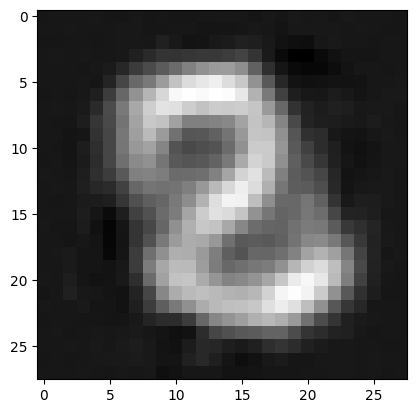

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.imshow(y_hat[0][0].detach().numpy(), cmap="gray")

### Save hyperparameters
The LightningModule allows you to automatically save all the hyperparameters passed to init simply by calling `self.save_hyperparameters()`.

```python
class MyLightningModule(LightningModule):
    def __init__(self, learning_rate, another_parameter, *args, **kwargs):
        super().__init__()
        self.save_hyperparameters()
```

The hyperparameters are saved to the "hyper_parameters" key in the checkpoint

```python
checkpoint = torch.load(checkpoint, map_location=lambda storage, loc: storage)
print(checkpoint["hyper_parameters"])
# {"learning_rate": the_value, "another_parameter": the_other_value}
```

The LightningModule also has access to the Hyperparameters

```python
model = MyLightningModule.load_from_checkpoint("/path/to/checkpoint.ckpt")
print(model.hparams.learning_rate)
```

### Save hyperparameters

## Resume training state
If you don't just want to load weights, but instead restore the full training, do the following:

In [20]:
model = LitAutoEncoder(Encoder(), Decoder())
trainer = L.Trainer(max_epochs=1, default_root_dir="lightning_logs")
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=valid_loader, ckpt_path="lightning_logs/lightning_logs/version_1/checkpoints/epoch=0-step=48000.ckpt")

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: Restoring states from the checkpoint path at lightning_logs/lightning_logs/version_1/checkpoints/epoch=0-step=48000.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/lightning_logs/version_1/checkpoints/epoch=0-step=480

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


## Disable checkpointing
You can disable checkpointing by passing:

```python
trainer = Trainer(enable_checkpointing=False)
```